/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


--- Training Started ---
Epoch 1/3:
  Train Loss: 0.3302, Val Loss: 0.1298, Val Accuracy: 0.9651
  --- Best validation accuracy improved, model saved (optional) ---
Epoch 2/3:
  Train Loss: 0.0699, Val Loss: 0.0346, Val Accuracy: 0.9869
  --- Best validation accuracy improved, model saved (optional) ---
Epoch 3/3:
  Train Loss: 0.0214, Val Loss: 0.0185, Val Accuracy: 1.0000
  --- Best validation accuracy improved, model saved (optional) ---
--- Training Finished ---
Best Validation Accuracy: 1.0000

--- Validation Set Evaluation ---
Classification Report:
              precision    recall  f1-score   support

         NLQ       1.00      1.00      1.00       157
          KS       1.00      1.00      1.00        72

    accuracy                           1.00       229
   macro avg       1.00      1.00      1.00       229
weighted avg       1.00      1.00      1.00       229


Confusion Matrix:


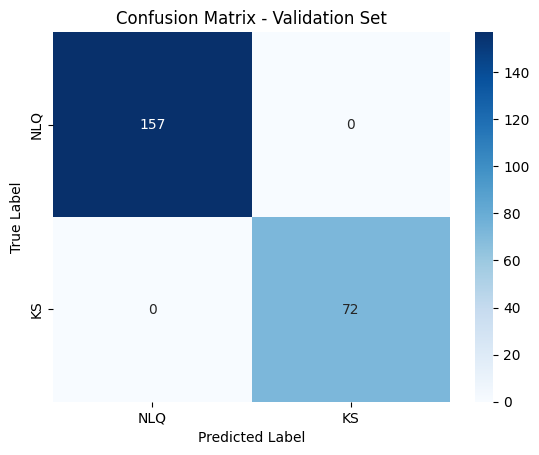


--- Example Predictions ---
Query: 'Where can I find cheap Samsung phones?'
Predicted Label: KS (Probability: 0.9794)
---
Query: 'Samsung tv price drop'
Predicted Label: NLQ (Probability: 0.9841)
---
Query: 'Tell me about the new galaxy Watch.'
Predicted Label: KS (Probability: 0.8343)
---
Query: 'galaxy buds features'
Predicted Label: NLQ (Probability: 0.9928)
---
Query: 'best noise cancelling headphones for work from home'
Predicted Label: KS (Probability: 0.8430)
---


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
LABEL_NLQ = "NLQ"
LABEL_KS = "KS"
LABELS = [LABEL_NLQ, LABEL_KS] # For mapping numerical labels back to strings

# 1. Load and Prepare Data
csv_file_path = 'ecommerce_queries.csv'
try:
    df = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_file_path}'.")
    exit()

# Map labels to numerical values
label_map = {LABEL_KS: 0, LABEL_NLQ: 1}
df['label_id'] = df['label'].map(label_map)

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id']) # Stratify for balanced splits

# 2. Load BERT Tokenizer and Model
MODEL_NAME = "bert-base-uncased"  # You can try other BERT variants
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # Binary classification

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

# 3. Create Dataset Class
class EcommerceQueryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        query_text = str(self.data.iloc[index]['query'])
        label = int(self.data.iloc[index]['label_id'])
        encoding = self.tokenizer.encode_plus(
            query_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt' # PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 4. Create DataLoaders
MAX_LEN = 128 # Maximum sequence length for BERT
BATCH_SIZE = 32

train_dataset = EcommerceQueryDataset(train_df, tokenizer, max_len=MAX_LEN)
val_dataset = EcommerceQueryDataset(val_df, tokenizer, max_len=MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Optimizer and Scheduler
EPOCHS = 3 # Adjust as needed
LEARNING_RATE = 2e-5 # Typical learning rate for BERT fine-tuning

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 6. Training Loop
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(dataloader)
    return avg_train_loss

def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels_cpu)

    avg_val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    return avg_val_loss, accuracy, all_labels, all_predictions


print("--- Training Started ---")
best_val_accuracy = 0
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    val_loss, val_accuracy, val_labels, val_predictions = evaluate_epoch(model, val_dataloader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save the best model (optional)
        # model.save_pretrained("./best_ecommerce_query_classifier")
        print("  --- Best validation accuracy improved, model saved (optional) ---")

print("--- Training Finished ---")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# 8. Evaluation Metrics and Report on Validation Set
print("\n--- Validation Set Evaluation ---")
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=LABELS))

print("\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()


# 9. Prediction Function (for new queries)
def predict_query_label(query_text, model, tokenizer, device, max_len=MAX_LEN, label_list=LABELS):
    model.eval() # Set model to evaluation mode
    encoding = tokenizer.encode_plus(
        query_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt' # PyTorch tensors
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1) # Get probabilities
        predicted_class_id = torch.argmax(probabilities, dim=-1).item() # Get class index

    predicted_label = label_list[predicted_class_id] # Map index back to label string
    return predicted_label, probabilities[0][predicted_class_id].item() # Return label and probability


# --- Example Prediction ---
example_queries = [
    "Where can I find cheap Samsung phones?",
    "Samsung tv price drop",
    "Tell me about the new galaxy Watch.",
    "galaxy buds features",
    "best noise cancelling headphones for work from home"
]

print("\n--- Example Predictions ---")
for query in example_queries:
    predicted_label, probability = predict_query_label(query, model, tokenizer, device)
    print(f"Query: '{query}'")
    print(f"Predicted Label: {predicted_label} (Probability: {probability:.4f})")
    print("---")

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
LABEL_NLQ = "NLQ"
LABEL_KS = "KS"
LABELS = [LABEL_NLQ, LABEL_KS] # For mapping numerical labels back to strings

# 1. Load and Prepare Data
csv_file_path = 'ecommerce_queries.csv'
try:
    df = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_file_path}'.")
    exit()

# Map labels to numerical values
label_map = {LABEL_KS: 0, LABEL_NLQ: 1}
df['label_id'] = df['label'].map(label_map)

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id']) # Stratify for balanced splits

# 2. Load BERT Tokenizer and Model
MODEL_NAME = "distilbert/distilbert-base-uncased"  # You can try other BERT variants
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # Binary classification

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

# 3. Create Dataset Class
class EcommerceQueryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        query_text = str(self.data.iloc[index]['query'])
        label = int(self.data.iloc[index]['label_id'])
        encoding = self.tokenizer.encode_plus(
            query_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt' # PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 4. Create DataLoaders
MAX_LEN = 128 # Maximum sequence length for BERT
BATCH_SIZE = 32

train_dataset = EcommerceQueryDataset(train_df, tokenizer, max_len=MAX_LEN)
val_dataset = EcommerceQueryDataset(val_df, tokenizer, max_len=MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 5. Optimizer and Scheduler
EPOCHS = 3 # Adjust as needed
LEARNING_RATE = 2e-5 # Typical learning rate for BERT fine-tuning

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 6. Training Loop
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(dataloader)
    return avg_train_loss

def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels_cpu)

    avg_val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    return avg_val_loss, accuracy, all_labels, all_predictions


print("--- Training Started ---")
best_val_accuracy = 0
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    val_loss, val_accuracy, val_labels, val_predictions = evaluate_epoch(model, val_dataloader, device)

    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Save the best model (optional)
        model.save_pretrained("./best_ecommerce_query_classifier")
        print("  --- Best validation accuracy improved, model saved (optional) ---")

print("--- Training Finished ---")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# 8. Evaluation Metrics and Report on Validation Set
print("\n--- Validation Set Evaluation ---")
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=LABELS))

print("\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()


# 9. Prediction Function (for new queries)
def predict_query_label(query_text, model, tokenizer, device, max_len=MAX_LEN, label_list=LABELS):
    model.eval() # Set model to evaluation mode
    encoding = tokenizer.encode_plus(
        query_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt' # PyTorch tensors
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1) # Get probabilities
        predicted_class_id = torch.argmax(probabilities, dim=-1).item() # Get class index

    predicted_label = label_list[predicted_class_id] # Map index back to label string
    return predicted_label, probabilities[0][predicted_class_id].item() # Return label and probability


# --- Example Prediction ---
example_queries = [
    "Where can I find cheap Samsung phones?",
    "Samsung tv price drop",
    "Tell me about the new galaxy Watch.",
    "galaxy buds features",
    "best noise cancelling headphones for work from home"
]

print("\n--- Example Predictions ---")
for query in example_queries:
    predicted_label, probability = predict_query_label(query, model, tokenizer, device)
    print(f"Query: '{query}'")
    print(f"Predicted Label: {predicted_label} (Probability: {probability:.4f})")
    print("---")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


--- Training Started ---


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels
LABEL_NLQ = "NLQ"
LABEL_KS = "KS"
LABELS = [LABEL_NLQ, LABEL_KS]

# Define models to compare (User can modify this list)
MODELS_TO_COMPARE = ["bert-base-uncased", "distilbert/distilbert-base-uncased"]  # Default models

# --- Data Loading and Preparation (same as before) ---
csv_file_path = 'ecommerce_queries.csv'
try:
    df = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_file_path}'.")
    exit()

label_map = {LABEL_KS: 0, LABEL_NLQ: 1}
df['label_id'] = df['label'].map(label_map)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label_id'])

# --- Dataset Class (same as before) ---
class EcommerceQueryDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        query_text = str(self.data.iloc[index]['query'])
        label = int(self.data.iloc[index]['label_id'])
        encoding = self.tokenizer.encode_plus(
            query_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# --- Training and Evaluation Functions (same as before) ---
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(dataloader)
    return avg_train_loss

def evaluate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels_cpu)

    avg_val_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)
    return avg_val_loss, accuracy, all_labels, all_predictions

# --- Prediction Function (same as before) ---
def predict_query_label(query_text, model, tokenizer, device, max_len=128, label_list=LABELS):
    model.eval()
    encoding = tokenizer.encode_plus(
        query_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=-1)
        predicted_class_id = torch.argmax(probabilities, dim=-1).item()

    predicted_label = label_list[predicted_class_id]
    return predicted_label, probabilities[0][predicted_class_id].item()

# --- Model Comparison Loop ---
model_performance_metrics = {} # Store performance metrics for each model

for model_name in MODELS_TO_COMPARE:
    print(f"\n--- Training and Evaluating Model: {model_name} ---")

    # 2. Load BERT Tokenizer and Model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 4. Create DataLoaders
    MAX_LEN = 128
    BATCH_SIZE = 32
    train_dataset = EcommerceQueryDataset(train_df, tokenizer, max_len=MAX_LEN)
    val_dataset = EcommerceQueryDataset(val_df, tokenizer, max_len=MAX_LEN)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 5. Optimizer and Scheduler
    EPOCHS = 3
    LEARNING_RATE = 2e-5
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_dataloader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # 6. Training and Evaluation Loop
    best_val_accuracy = 0
    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        val_loss, val_accuracy, val_labels, val_predictions = evaluate_epoch(model, val_dataloader, device)
        print(f"Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

    # 8. Store Evaluation Metrics
    print(f"\n--- {model_name} Validation Set Evaluation ---")
    report = classification_report(val_labels, val_predictions, target_names=LABELS, output_dict=True)
    cm = confusion_matrix(val_labels, val_predictions)

    model_performance_metrics[model_name] = {
        'accuracy': best_val_accuracy, # Use best accuracy achieved during training
        'precision_NLQ': report[LABEL_NLQ]['precision'],
        'recall_NLQ': report[LABEL_NLQ]['recall'],
        'f1-score_NLQ': report[LABEL_NLQ]['f1-score'],
        'precision_KS': report[LABEL_KS]['precision'],
        'recall_KS': report[LABEL_KS]['recall'],
        'f1-score_KS': report[LABEL_KS]['f1-score'],
        'confusion_matrix': cm
    }

    print("Classification Report:")
    print(classification_report(val_labels, val_predictions, target_names=LABELS))
    print("\nConfusion Matrix:")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name} - Validation Set')
    plt.show()

# --- Performance Comparison Chart ---
model_names = list(model_performance_metrics.keys())
accuracy_scores = [model_performance_metrics[name]['accuracy'] for name in model_names]
f1_scores_nlq = [model_performance_metrics[name]['f1-score_NLQ'] for name in model_names]
f1_scores_ks = [model_performance_metrics[name]['f1-score_KS'] for name in model_names]

x = range(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x, accuracy_scores, width=width, label='Accuracy')
plt.bar([i + width for i in x], f1_scores_nlq, width=width, label=f'F1-Score ({LABEL_NLQ})')
plt.bar([i + 2*width for i in x], f1_scores_ks, width=width, label=f'F1-Score ({LABEL_KS})')

plt.xticks([i + width for i in x], model_names, rotation=45, ha='right')
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('Performance Comparison of BERT Models')
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Model Comparison Completed ---")

# --- Example Prediction using the first model in the list (you can change this) ---
best_model_name = MODELS_TO_COMPARE[0] # Or choose based on comparison chart
best_tokenizer = AutoTokenizer.from_pretrained(best_model_name)
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_name, num_labels=2).to(device)
# Load the fine-tuned weights (if you saved them, otherwise, use the model after the last training loop)
# best_model = AutoModelForSequenceClassification.from_pretrained("./best_ecommerce_query_classifier").to(device) # Example if you saved

example_queries = [
    "Where can I find cheap Samsung phones?",
    "Samsung tv price drop",
    "Tell me about the new galaxy Watch.",
    "galaxy buds features",
    "best noise cancelling headphones for work from home"
]

print(f"\n--- Example Predictions using {best_model_name} ---")
for query in example_queries:
    predicted_label, probability = predict_query_label(query, best_model, best_tokenizer, device)
    print(f"Query: '{query}'")
    print(f"Predicted Label: {predicted_label} (Probability: {probability:.4f})")
    print("---")